<a href="https://colab.research.google.com/github/LongNguyen1984/GANLearning/blob/main/CGANmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introductin
This programe implement a sample of Conditional GAN 

In [1]:
from keras.datasets.fashion_mnist import load_data
#  load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4431872/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


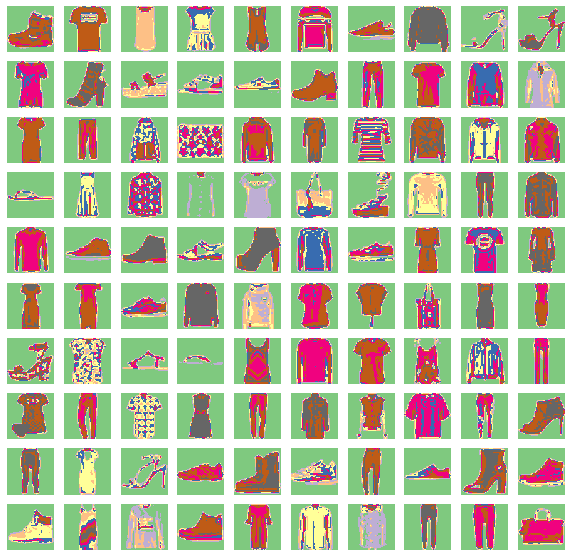

In [9]:
import matplotlib.pyplot as plt

# plot a raw pixel data
plt.figure(figsize=(10,10))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(trainX[i], cmap='Accent')
  plt.axis('off')
plt.show()

In [11]:
trainy[0:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

### Using Uncoditional GAN

### Install tensorflow_addon

In [13]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 9.2 MB/s 


In [62]:
from random import random
import os
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy import expand_dims
from numpy.random import randint
from numpy.random import randn
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Flatten, Dropout, Dense, Reshape
import tensorflow_addons as tfa

In [49]:
def define_discriminator(in_shape=(28,28,1)):
  #model = Sequential()
  
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # sorce image input
  in_image = Input(shape=in_shape)
  # downsample
  d = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
  d = LeakyReLU(alpha=0.2)(d)
  # downsample
  d = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # Classifier
  d = Flatten()(d)
  d = Dropout(0.4)(d)
  output = Dense(1, activation='sigmoid')(d)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model = Model(in_image, output)
  # compile model
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [55]:
def define_generator(latent_dim):
  # image_input
  init = RandomNormal(stddev=0.02)
  # foudation for 7*7 image
  input = Input(shape = latent_dim)
  n_nodes = 128*7*7
  d = Dense(n_nodes)(input)
  d = LeakyReLU(alpha=0.2)(d)
  d = Reshape((7,7,128))(d)
  # Upsample to 14x14
  d = Conv2DTranspose(128,(4,4), strides=(2,2),padding='same')(d)
  d = LeakyReLU(alpha=0.2)(d)
  # Upsample to 28x28
  d = Conv2DTranspose(128,(4,4), strides=(2,2),padding='same')(d)
  d = LeakyReLU(alpha=0.2)(d)
  # generate
  g = Conv2DTranspose(1, (7,7), padding='same', kernel_initializer=init)(d)
  output = Activation('tanh')(g)
  # define model
  model = Model(input, output)
  return model

In [59]:
# define the combined generator and discrimator model, for update the generator
def define_gan(generator, discriminator, latent_dim):
  # make weights in the discriminator not trainable
  discriminator.trainable = False
  # connect them
  input_gen = Input(shape = latent_dim)
  gen_out = generator(input_gen)
  output_d = discriminator(gen_out)
  model = Model(input_gen, output_d)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

# load fashion mnist images
def load_real_samples():
  # load dataset
  (trainX, _), (_, _) = load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # select images
  X = dataset[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

#use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = generator.predict(x_input)
  # create class labels
  y = zeros((n_samples, 1))
  return X, y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected ✬real✬ samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate ✬fake✬ examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator✬s error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
  g_model.save('generator.h5')

In [37]:
import numpy as np

np.shape(np.unique(trainy))

(10,)

In [45]:
dataset = load_real_samples()

In [ ]:
# size of the latent space
latent_dim = 100
# load image data
dataset = load_real_samples()
image_shape = dataset.shape[1:]
# create the discriminator
discriminator = define_discriminator(image_shape)
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator, latent_dim=latent_dim)

# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, 1/468, d1=0.685, d2=0.695 g=0.692
>1, 2/468, d1=0.649, d2=0.696 g=0.691
>1, 3/468, d1=0.621, d2=0.698 g=0.689
>1, 4/468, d1=0.594, d2=0.703 g=0.684
>1, 5/468, d1=0.551, d2=0.712 g=0.676
>1, 6/468, d1=0.525, d2=0.727 g=0.664
>1, 7/468, d1=0.474, d2=0.747 g=0.649
>1, 8/468, d1=0.441, d2=0.769 g=0.641
>1, 9/468, d1=0.406, d2=0.780 g=0.646
>1, 10/468, d1=0.415, d2=0.769 g=0.662
>1, 11/468, d1=0.379, d2=0.734 g=0.708
>1, 12/468, d1=0.393, d2=0.677 g=0.766
>1, 13/468, d1=0.370, d2=0.622 g=0.850
>1, 14/468, d1=0.330, d2=0.548 g=0.964
>1, 15/468, d1=0.339, d2=0.482 g=1.057
>1, 16/468, d1=0.330, d2=0.446 g=1.092
>1, 17/468, d1=0.333, d2=0.481 g=1.015
>1, 18/468, d1=0.269, d2=0.542 g=0.897
>1, 19/468, d1=0.293, d2=0.609 g=0.790
>1, 20/468, d1=0.253, d2=0.662 g=0.730
>1, 21/468, d1=0.264, d2=0.759 g=0.653
>1, 22/468, d1=0.269, d2=0.995 g=0.497
>1, 23/468, d1=0.225, d2=1.218 g=0.405
>1, 24/468, d1=0.231, d2=1.354 g=0.365
>1, 25/468, d1=0.163, d2=1.409 g=0.379
>1, 26/468, d1=0.183, d2=1.252 g=0

In [51]:
discriminator.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 flatten_5 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_5 (Dropout)         (None, 6272)              0   

In [57]:
generator.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_14 (Dense)            (None, 6272)              633472    
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                          